# Recommending an item to purchase 

### For my previous job, I wanted to build a recommendation system to help boost sales. 

#### There are  3 tasks:
##### 1) Visualize the top 50 experiments Science Exchange sells. 
##### 2) Create recommendations for items to purchase - assessing the similarity between items by using the data of users and the items they purchased together (cosine similarity). 
##### 3) Visualize how many experiments Science Exchange sells compared to those that are never sold. 

In [1]:
#need to connect to mySQL database
import MySQLdb

#usual imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from bokeh.plotting import figure,show,output_notebook
output_notebook()

%matplotlib inline

# Statsmodel APIs
import statsmodels.api as sm

Loading BokehJS ...

In [2]:
df_clean = pd.read_csv('/Users/sheena/Desktop/Sheenas_code/DAT_SF_18/FINAL_project/df_clean.csv')
len(df_clean.experiment_type_id.unique())

850

In [6]:
len(df_clean.user_id.unique())

4888

In [3]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13315 entries, 0 to 13314
Data columns (total 4 columns):
Unnamed: 0            13315 non-null int64
user_id               13315 non-null float64
experiment_type_id    13315 non-null float64
created_at            13315 non-null object
dtypes: float64(2), int64(1), object(1)
memory usage: 416.2+ KB


In [4]:
df_clean['Purchased'] = 1 # Add a columns of 1s to mean 'quote purchased' and this is what we'll pivot on

In [5]:
df_clean.head()

,Unnamed: 0,user_id,experiment_type_id,created_at,Purchased
0,0,11.0,936.0,2011-06-24 13:09:09,1
1,1,11.0,226.0,2011-06-24 14:26:05,1
2,2,8.0,36.0,2011-06-30 10:39:30,1
3,3,3.0,853.0,2011-06-30 15:48:35,1
4,4,13.0,108.0,2011-06-30 20:01:42,1


#### I am using another MySQL database that has the names associated with each experiment ID. I've made it a CSV file so that it can be accessed outside of work. I will replace the experiment id #s with the experiment types

In [7]:
expt_names = pd.read_csv('/Users/sheena/Desktop/Sheenas_code/df_exp.csv')
len(expt_names) #there are some experiments never purchased

7258

In [8]:
experiment_lookup = {}
for rec in expt_names.to_dict(orient='records'):
    experiment_lookup[rec['id']] = rec['name']

In [9]:
expt_names.head()

,id,name
0,7212,(1 H -Benzoimidazol-2-yl)-acetic acid
1,7185,"(1S)-1-[5-[(2,4-Dichlorophenyl)methylsulfanyl]..."
2,7159,(2-Methoxyphenyl)(piperazin-1-yl)methanone
3,7177,"(2R,4S)-1-((Benzyloxy)carbonyl)-4-isopropyl-2-..."
4,7205,"(2R,4S)-1-(tert-Butoxycarbonyl)-4-phenylpiperi..."


#### Task 1: Visualize the top 50 experiments we sell.

In [10]:
n = 50
top_n = df_clean.experiment_type_id.value_counts().index[:n] #the top 50 experiments based on the number of times they were purchased

In [11]:
df_50 = df_clean[df_clean.experiment_type_id.isin(top_n)]
df_50.head()

,Unnamed: 0,user_id,experiment_type_id,created_at,Purchased
0,0,11.0,936.0,2011-06-24 13:09:09,1
1,1,11.0,226.0,2011-06-24 14:26:05,1
4,4,13.0,108.0,2011-06-30 20:01:42,1
5,5,11.0,17.0,2011-07-04 17:29:28,1
11,11,62.0,936.0,2011-08-10 22:52:32,1


In [12]:
df_50.experiment_type_id

0         936.0
1         226.0
4         108.0
5          17.0
11        936.0
12         59.0
18        101.0
21        846.0
22         38.0
25         44.0
31       2844.0
34        235.0
35        235.0
41         59.0
43        235.0
45        936.0
46         44.0
48         38.0
51        936.0
52        851.0
59        145.0
61         17.0
67        654.0
68         38.0
70         59.0
71         17.0
73         59.0
74        824.0
75        859.0
78        846.0
          ...  
13273    1306.0
13274    1306.0
13276      17.0
13277     848.0
13278     848.0
13279     848.0
13283     851.0
13284     200.0
13285     413.0
13286     413.0
13291     145.0
13292       6.0
13293     145.0
13294     848.0
13295     145.0
13297     145.0
13298     145.0
13299    1513.0
13300    2844.0
13301    2844.0
13302    2844.0
13304     859.0
13305     226.0
13306     226.0
13307     226.0
13308     859.0
13309     848.0
13310    3170.0
13311     219.0
13314    1306.0
Name: experiment_type_id

In [13]:
df_50.is_copy = False

In [14]:
df_50.experiment_type_id = df_50.experiment_type_id.map(lambda x : experiment_lookup[x])

In [15]:
df_50.head()

,Unnamed: 0,user_id,experiment_type_id,created_at,Purchased
0,0,11.0,Molecular cloning,2011-06-24 13:09:09,1
1,1,11.0,Methylation analysis,2011-06-24 14:26:05,1
4,4,13.0,FISH,2011-06-30 20:01:42,1
5,5,11.0,Bioinformatics,2011-07-04 17:29:28,1
11,11,62.0,Molecular cloning,2011-08-10 22:52:32,1


In [16]:
a = df_50.experiment_type_id.value_counts() #top 50 by times purchased

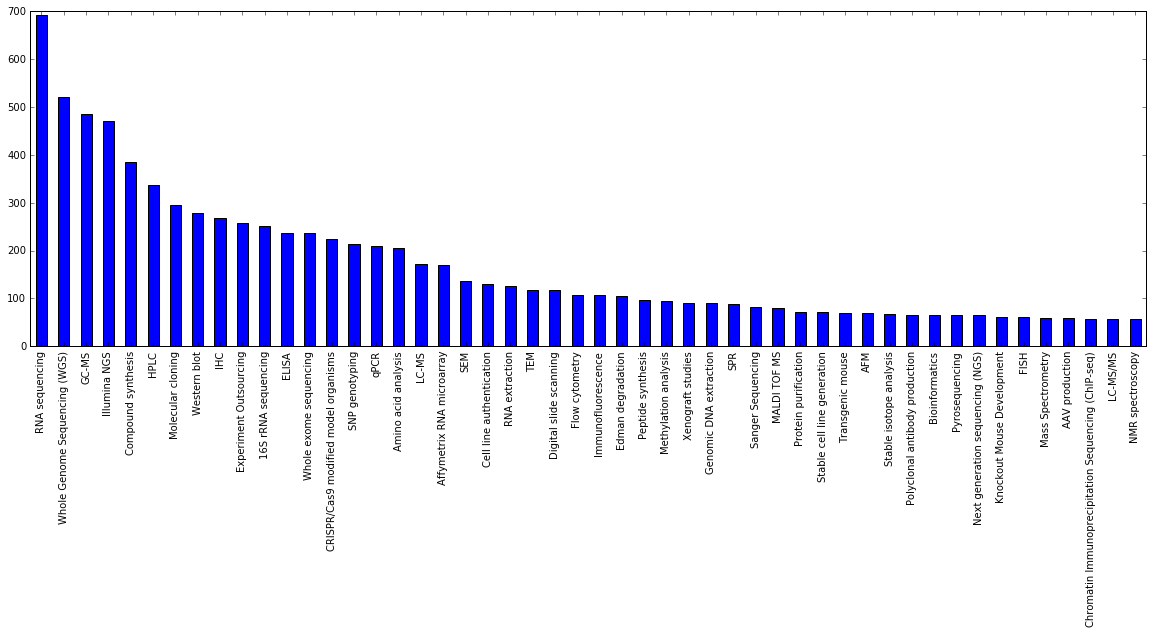

In [17]:
a.plot(kind='bar', figsize = (20,6))

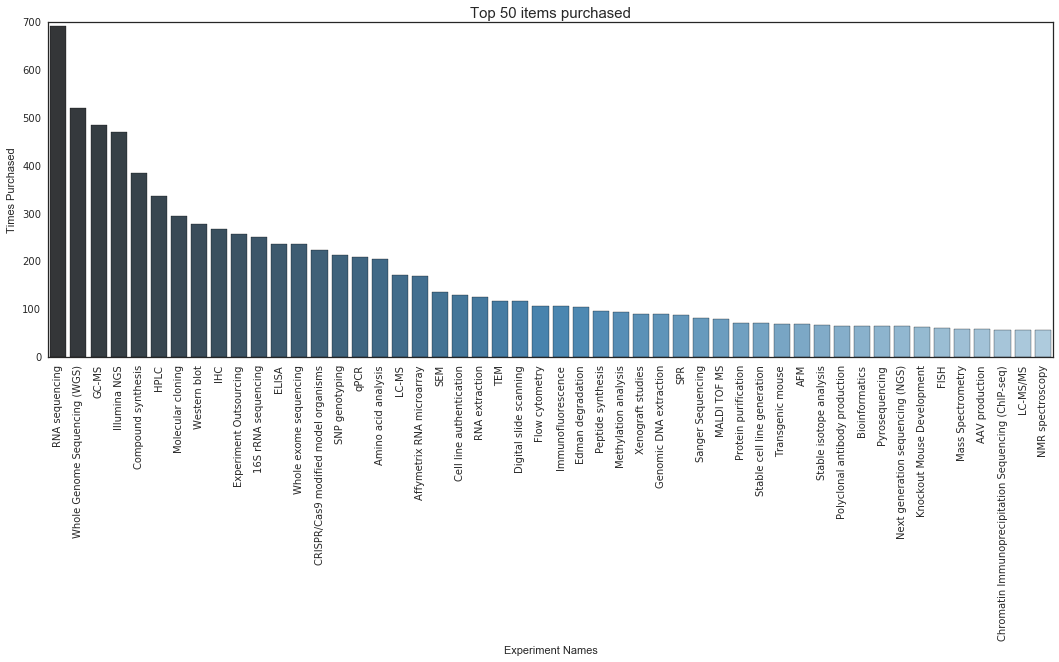

In [21]:
#a seaborn plot might be prettier 
import seaborn as sns
from cycler import cycler

sns.set(style="white")

f, (ax1) = plt.subplots(1,figsize=(18,6))
ax1 = sns.barplot(x = a.index, y = df_50.experiment_type_id.value_counts(), data=df_50, palette ='Blues_d')
ax1.set(xlabel='Experiment Names', ylabel='Times Purchased')
ax1.set_title('Top 50 items purchased', size = 15)
for item in ax1.get_xticklabels():
    item.set_rotation(90)
plt.savefig('Expt_valuecounts.jpg')
plt.show()


###### Task 2: Recommendation System - Pivot Table Time

In [22]:
df_pivot = pd.pivot_table(df_clean, values=["Purchased"],
        columns=["experiment_type_id", "user_id"],
        aggfunc=np.sum) 

In [23]:
df_pivot.head()

           experiment_type_id  user_id
Purchased  2.0                 3.0        2
                               3981.0     1
                               6310.0     2
                               8068.0     2
                               8670.0     1
dtype: int64

In [24]:
df_wide = df_pivot.unstack(-1)
df_wide.head()

user_id                       2.0      3.0      8.0      11.0     13.0     \
          experiment_type_id                                                
Purchased 2.0                     NaN      2.0      NaN      NaN      NaN   
          5.0                     NaN      NaN      NaN      NaN      NaN   
          6.0                     NaN      NaN      NaN      NaN      NaN   
          8.0                     NaN      NaN      NaN      NaN      NaN   
          17.0                    NaN      1.0      NaN      1.0      NaN   

user_id                       14.0     21.0     28.0     34.0     37.0     \
          experiment_type_id                                                
Purchased 2.0                     NaN      NaN      NaN      NaN      NaN   
          5.0                     NaN      NaN      NaN      NaN      NaN   
          6.0                     NaN      NaN      NaN      NaN      NaN   
          8.0                     NaN      NaN      NaN      NaN      NaN   
          17.0                    NaN      NaN      NaN      NaN      NaN   

user_id                        ...     14219.0  14220.0  14221.0  14223.0  \
          experiment_type_id   ...                                          
Purchased 2.0                  ...         NaN      NaN      NaN      NaN   
          5.0                  ...         NaN      NaN      NaN      NaN   
          6.0                  ...         NaN      1.0      NaN      NaN   
          8.0                  ...         NaN      NaN      NaN      NaN   
          17.0                 ...         NaN      NaN      NaN      NaN   

user_id                       14224.0  14225.0  14226.0  14227.0  14228.0  \
          experiment_type_id                                                
Purchased 2.0                     NaN      NaN      NaN      NaN      NaN   
          5.0                     NaN      NaN      NaN      NaN      NaN   
          6.0                     NaN      NaN      NaN      NaN      NaN   
          8.0                     NaN      NaN      NaN      NaN      NaN   
          17.0                    NaN      NaN      NaN      NaN      NaN   

user_id                       14230.0  
          experiment_type_id           
Purchased 2.0                     NaN  
          5.0                     NaN  
          6.0                     NaN  
          8.0                     NaN  
          17.0                    NaN  

[5 rows x 4888 columns]

In [25]:
df_wide = df_wide.fillna(0)

In [26]:
df_wide.columns[:10] #checking that the columns are user ids

Float64Index([2.0, 3.0, 8.0, 11.0, 13.0, 14.0, 21.0, 28.0, 34.0, 37.0], dtype='float64', name=u'user_id')

In [27]:
df_wide.index.levels[0]
experiment_id = df_wide.index.levels[1]
experiment_id # checking that rows are experiment ids. YAY.

Float64Index([   2.0,    5.0,    6.0,    8.0,   17.0,   20.0,   21.0,   26.0,
                32.0,   35.0,
              ...
              7278.0, 7523.0, 7766.0, 7792.0, 8621.0, 8894.0, 9331.0, 9724.0,
              9845.0, 9867.0],
             dtype='float64', name=u'experiment_type_id', length=850)

In [28]:
from sklearn.metrics.pairwise import cosine_similarity

In [29]:
dists = cosine_similarity(df_wide)
dists

array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.]])

In [30]:
#now we're making dists a df so we can work with it
dists = pd.DataFrame(dists)
dists.columns = experiment_id
dists.index = experiment_id
dists.head(4)

experiment_type_id,2.0,5.0,6.0,8.0,17.0,20.0,21.0,26.0,32.0,35.0,...,7278.0,7523.0,7766.0,7792.0,8621.0,8894.0,9331.0,9724.0,9845.0,9867.0
experiment_type_id,,,,,,,,,,,,,,,,,,,,,
2.0,1.0,0.0,0.0,0.0,0.041082,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.365148,0.0,0.000000,0.0,0.0,0.0,0.000000
5.0,0.0,1.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000
6.0,0.0,0.0,1.0,0.0,0.008363,0.008760,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000
8.0,0.0,0.0,0.0,1.0,0.060138,0.031497,0.0,0.0,0.0,0.0,...,0.0,0.188982,0.0,0.000000,0.0,0.188982,0.0,0.0,0.0,0.109109


In [31]:
dists.index = dists.index.map(lambda x : experiment_lookup[int(x)])
dists.columns = dists.columns.map(lambda x : experiment_lookup[int(x)])

In [32]:
import gzip
import dill

In [33]:
with gzip.open('dists.dill.gz', 'w') as ff:
   dill.dump(dists, ff)
#This is to be able to make a basic website 

#### Task 2: Recommendation System - Create for loop to report top recommendations

In [34]:
dists.head()

,Animal husbandry,Atom probe tomography (APT),AFM,Biobanking,Bioinformatics,Confocal microscopy,Copy number variation analysis,Electron microscopy,Functional Magnetic Resonance Imaging,Genotyping,...,Metabolite Generation,Plasmid DNA preparation,Bioanalysis Services,Human Biospecimens,Cell Cycle Analysis - FACS,Vaporized Hydrogen Peroxide Sterilization,Drug Development Services,MTT and MTS Assays,Knock-out Bacteria,Custom Competent Cell Production
Animal husbandry,1.000000,0.0,0.000000,0.000000,0.041082,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.365148,0.0,0.000000,0.0,0.0,0.0,0.000000
Atom probe tomography (APT),0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000
AFM,0.000000,0.0,1.000000,0.000000,0.008363,0.008760,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000
Biobanking,0.000000,0.0,0.000000,1.000000,0.060138,0.031497,0.0,0.0,0.000000,0.0,...,0.0,0.188982,0.0,0.000000,0.0,0.188982,0.0,0.0,0.0,0.109109
Bioinformatics,0.041082,0.0,0.008363,0.060138,1.000000,0.079556,0.0,0.0,0.079556,0.0,...,0.0,0.318223,0.0,0.000000,0.0,0.318223,0.0,0.0,0.0,0.183726


In [35]:
dists.info()

<class 'pandas.core.frame.DataFrame'>
Index: 850 entries, Animal husbandry to Custom Competent Cell Production
Columns: 850 entries, Animal husbandry to Custom Competent Cell Production
dtypes: float64(850)
memory usage: 5.5+ MB


In [36]:
for row in dists.iterrows():
    a = row[1].values
    top3 = sorted(range(len(a)), key=lambda i: a[i])[-3:]
    print row[1].iloc[top3].sort_values(ascending=False)

Animal husbandry      1.000000
Mouse rederivation    0.878310
Microplate            0.730297
Name: Animal husbandry, dtype: float64
Atom probe tomography (APT)         1.0
Custom Competent Cell Production    0.0
Knock-out Bacteria                  0.0
Name: Atom probe tomography (APT), dtype: float64
AFM                               1.000000
Secondary ion mass spectometry    0.420471
Thermal conductivity analysis     0.297318
Name: AFM, dtype: float64
Biobanking                                   1.000000
Vaporized Hydrogen Peroxide Sterilization    0.188982
Plasmid DNA preparation                      0.188982
Name: Biobanking, dtype: float64
Bioinformatics            1.000000
NGS library prep          0.477334
Genomics Data Analysis    0.397779
Name: Bioinformatics, dtype: float64
Confocal microscopy                          1.000000
Microscopy                                   0.333333
Vaporized Hydrogen Peroxide Sterilization    0.166667
Name: Confocal microscopy, dtype: float64
Co

#### Task 3: I want to know how many experiment types we have never sold.

In [37]:
len(pd.Index(experiment_lookup.values()).difference(dists.columns)) #expts never purchased or inactive expts

6408

In [38]:
df_clean.experiment_type_id.value_counts().count() #This is how many expt types were purchased or active expts

850

In [39]:
len(expt_names) #This was the total list of expts

7258

In [40]:
active_users = df_clean.user_id.value_counts().count() #This is how many users purchase expts or active users

In [41]:
active_users

4888

In [42]:
df_users = pd.read_csv('/Users/sheena/Desktop/Sheenas_code/data/df_users.csv')
total_users = len(df_users.id.unique()) #total users from 3rd dataset - accessed from MySQL and saved as CSV

In [43]:
#total users - active users = inactive users
total_users - active_users

9041

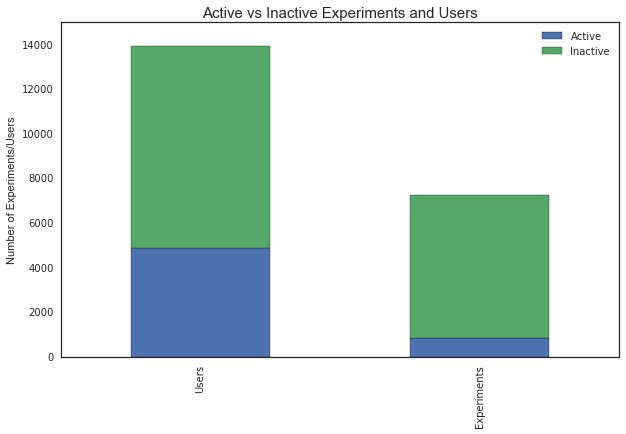

In [44]:
d = {'Inactive': [9041, 6408], 'Active': [4888, 850]}
df = pd.DataFrame(data=d, index=['Users', 'Experiments'])
h = df.plot(kind='bar', stacked=True
        , figsize = (10,6))
h.set_ylim([0,15000])
h.set(ylabel='Number of Experiments/Users')
h.set_title('Active vs Inactive Experiments and Users', size = 15)